# XGB model cv selection scoring

- `xgboost.cv`
- Comparing the optimal candidates by test set, using the g-research weighted correlation metrics.

In [22]:
import os
import pandas as pd
import gc
import talib as ta
import numpy as np
import json
import pickle

## 1. version_num

- `model_nof_{version number}`

In [23]:
version_num = 42
retrained = False#set to False to get correct out-train score
if retrained:
    MOD_FOLDER = "./trainedXGB/retrained" + f"/model_nof_{version_num}_sub_sub"
else:
    MOD_FOLDER = "./trainedXGB" + f"/model_nof_{version_num}"

## 2. organized data set  

- new_data.ftr

In [24]:
df_train = pd.read_feather('./data'+'/new_data.ftr',
                           columns=['timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close',
                                'Volume', 'Target', 'Weight', 'lr_15', 'Mkt_lrt_15','Crypto_Index','beta','lr_mkt_resid'])

## 3. Features

In [25]:
# psets34 = dict(zip(['lrtn','fastk1','fastk2','adx','macd_s','macd_l','rsi','std_Crypto_Index','std_lr_15','std_Mkt_lrt_15'],
#                    [15, 15, 5, 30, 5, 25, 60, 5, 15, 30]))
with open("./trainedXGB" + f"/model_nof_{version_num}" + f"/feature_best{version_num}", "rb") as f:
    psets=pickle.load(f)
    
psets

{'std_lr_15': 30,
 'std_Mkt_lrt_15': 10,
 'std_Crypto_Index': 30,
 'rsi': 30,
 'macd_sig': 15,
 'macd_s': 10,
 'macd_l': 60,
 'lrtn': 50,
 'fastk2': 10,
 'fastk1': 10,
 'beta_s': '6h',
 'beta_l': '2d',
 'adx': 50}

In [26]:
######mod>=36
def log_return(series, periods=5):
    return np.log(series).diff(periods)

def beta_resid(df, window): 
    num, unit = int(window[:-1]),window[-1]
    if unit == 'h':
        width = 60*num
    elif unit == 'd':
        width = 60*24*num
    b = ((ta.MULT(df.Mkt_lrt_15,df.lr_15).rolling(width).mean())/ \
        (ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).rolling(width).mean())).rename(f"beta_{window}")
    b = b.replace([np.nan,np.inf,-np.inf], 0)
    resids = ta.SUB(df.lr_15, ta.MULT(b, df.Mkt_lrt_15)).rename(f"lr_15_resid_{window}")
    return pd.concat([b, resids],axis=1)

def lag_features(df,fastk1,fastk2,adx,macd_s,macd_l,macd_sig,rsi,std_Crypto_Index,std_lr_15,std_Mkt_lrt_15,**kwargs):    
    ####TECH indicators
    df['slowK'], df['slowD'] = ta.STOCH(df.High, df.Low, df.Close, 
                                        fastk_period=fastk1, slowk_period=int(3*fastk1/5), slowd_period=int(3*fastk1/5),
                                        slowk_matype=0, slowd_matype=0)
    df['fastK'], df['fastD'] = ta.STOCHF(df.High, df.Low, df.Close,
                                         fastk_period=fastk2, fastd_period=int(3*fastk2/5), 
                                         fastd_matype=0)
    df[f'rsi_{rsi}'] = ta.RSI(df['Close'], timeperiod=rsi)
    df[f'macd_{macd_s}_{macd_l}'],df[f'macd_signal_{macd_sig}'], df['macd_hist'] = \
                ta.MACD(df['Close'],fastperiod=macd_s, slowperiod=macd_l, signalperiod=macd_sig)
    df[f'adx_{adx}'] = ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=adx)#Average Directional Movement Index
    df['AD'] = ta.AD(df['High'], df['Low'],df['Close'], df['Volume'])#Accumulation Distribution Line
    ####std volatility
    df[f'std_lr_15_{std_lr_15}'] = ta.STDDEV(df.lr_15,timeperiod=std_lr_15, nbdev=1)
    df[f'std_Mkt_lrt_15_{std_Mkt_lrt_15}'] = ta.STDDEV(df.Mkt_lrt_15,timeperiod=std_Mkt_lrt_15, nbdev=1)
    df[f'std_Crypto_Index_{std_Crypto_Index}'] = ta.STDDEV(df.Crypto_Index,timeperiod=std_Crypto_Index, nbdev=1)

def get_features(df_feat, fpara_dict):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat[[f"beta_{fpara_dict['beta_s']}",f"lr_15_resid_{fpara_dict['beta_s']}"]] = beta_resid(df_feat, window = fpara_dict['beta_s'])
    df_feat[[f"beta_{fpara_dict['beta_l']}",f"lr_15_resid_{fpara_dict['beta_l']}"]] = beta_resid(df_feat, window = fpara_dict['beta_l'])
    df_feat[f"lrtn_index_{fpara_dict['lrtn']}"] = log_return(df_feat.Crypto_Index, fpara_dict['lrtn'])
    lag_features(df_feat, **fpara_dict)
    return df_feat

## 4. Test set with features

- train set range is after `df_train['timestamp'].quantile(0.5)`
- test set

In [27]:
df_train['timestamp'].quantile(0.5)

int(pd.Timestamp('2021-09-21T00:00:00').timestamp())
pd.to_datetime(df_train['timestamp'].quantile(0.95),unit="s",
               infer_datetime_format=True)

Timestamp('2021-11-05 07:18:57')

In [28]:
import datetime
import time

#test_days= 30*3
def make_testset(df_train, start,end, psets):
    dd = df_train[(start<=df_train['timestamp']) & (df_train['timestamp']<=end)].copy()
    ###consistent timestamp for all 14 assets
    dd = dd.sort_values('timestamp').set_index("timestamp").sort_index()
    ind = dd.index.unique()
    def reindex(df):
        df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
        df = df.fillna(method="ffill").fillna(method="bfill")
        return df
    dd = dd.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
    ###add features
    dd = dd.groupby('Asset_ID').apply(lambda x: get_features(x,psets))
    dd.dropna(axis = 0, inplace= True)
    return dd.reset_index()

## Performance on test set

In [29]:
import xgboost as xgb
from os.path import exists

ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

def model_reload_train():
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        model_file = MOD_FOLDER + f"/model_{asset_id}.json"
        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

In [30]:
from script.weighted_corr_metrics import weighted_correlation
pd.options.mode.chained_assignment = None  # default='warn'

result = []#out-train
result2 = []#in-train
models = {}

models[version_num] = model_reload_train()
################################################out-train test
test_end= df_train['timestamp'].max()
test_start= df_train['timestamp'].quantile(0.95)
df_test = make_testset(df_train, test_start,test_end, psets)
#############################################in-train test same as API
test_end2= 1632182400
test_start2= 1623542400 - 60*64
df_test2 = make_testset(df_train, test_start2,test_end2, psets)

result_id=[]
result_id2=[]
for id in range(0,14):
    model = models[version_num][id]
    x = df_test[df_test['Asset_ID']==id]
    x['Pred'] = model.predict(xgb.DMatrix(x[model.feature_names]))
    result_id.append(x[['timestamp','Asset_ID','Weight','Target','Pred']])
    x2 = df_test2[df_test2['Asset_ID']==id]
    x2['Pred2'] = model.predict(xgb.DMatrix(x2[model.feature_names]))
    result_id2.append(x2[['timestamp','Asset_ID','Weight','Target','Pred2']])
    
result.append(pd.concat(result_id, axis=0))
result2.append(pd.concat(result_id2, axis=0))
score=weighted_correlation(a=result[-1]['Target'], 
                    b=result[-1]['Pred'], 
                    weights=result[-1]['Weight'])
score2=weighted_correlation(a=result2[-1]['Target'], 
                    b=result2[-1]['Pred2'], 
                    weights=result2[-1]['Weight'])

print(f'{MOD_FOLDER} finished. Out-train-score:{score}, In-train-score:{score2}')    


KeyError: 0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

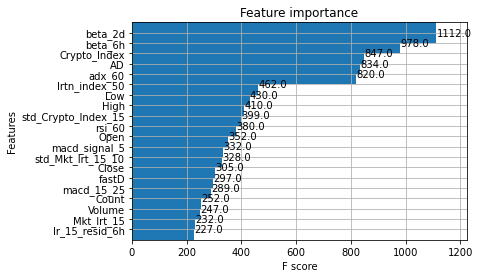

In [ ]:
xgb.plot_importance(models[version_num][0], max_num_features=20, height=2)

In [ ]:
models[version_num][0].feature_names

['Count',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'lr_15',
 'Mkt_lrt_15',
 'Crypto_Index',
 'beta_6h',
 'lr_15_resid_6h',
 'beta_2d',
 'lr_15_resid_2d',
 'lrtn_index_50',
 'slowK',
 'slowD',
 'fastK',
 'fastD',
 'rsi_60',
 'macd_15_25',
 'macd_signal_5',
 'macd_hist',
 'adx_60',
 'AD',
 'std_lr_15_5',
 'std_Mkt_lrt_15_10',
 'std_Crypto_Index_15']

In [ ]:
round(0.00199,5)

0.00199

In [ ]:
ttt = 0
with open('./pickletest', 'wb') as f:
    pickle.dump(ttt, f)
    
with open('./pickletest', 'wb') as f:
    pickle.dump(ttt+2,f)

In [ ]:
with open('./pickletest','rb') as ff:
    t = pickle.load(ff)
t

2